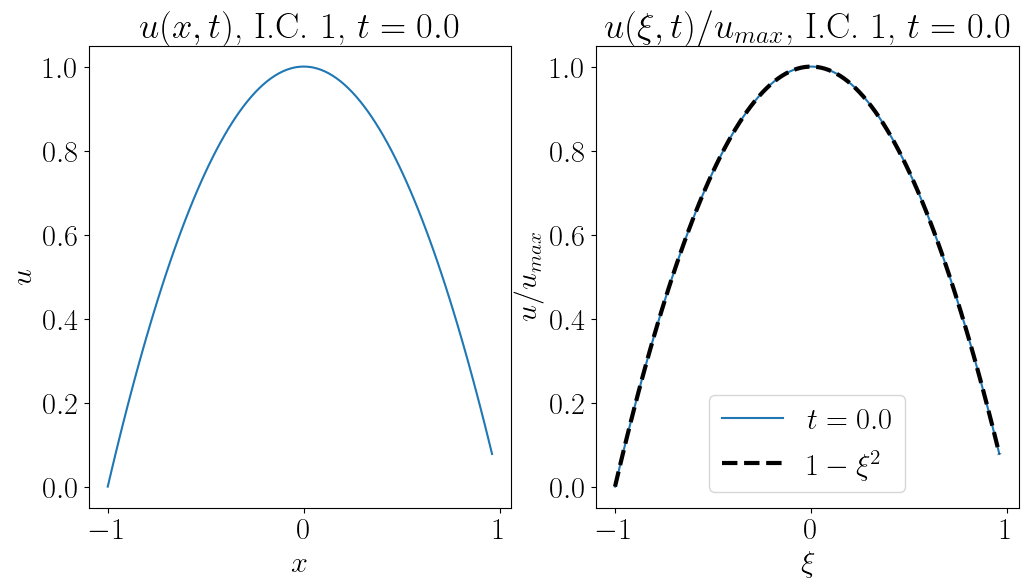

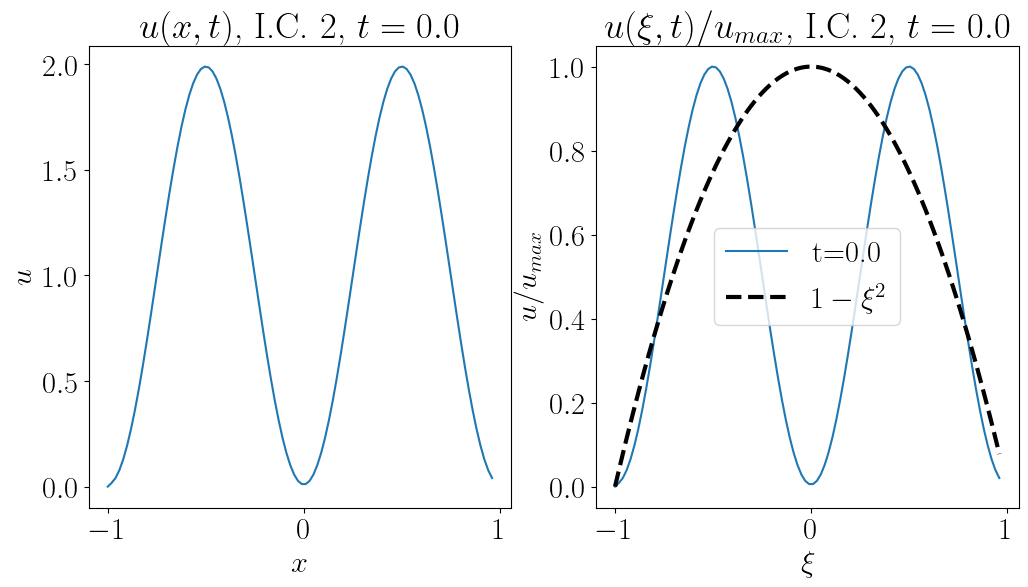

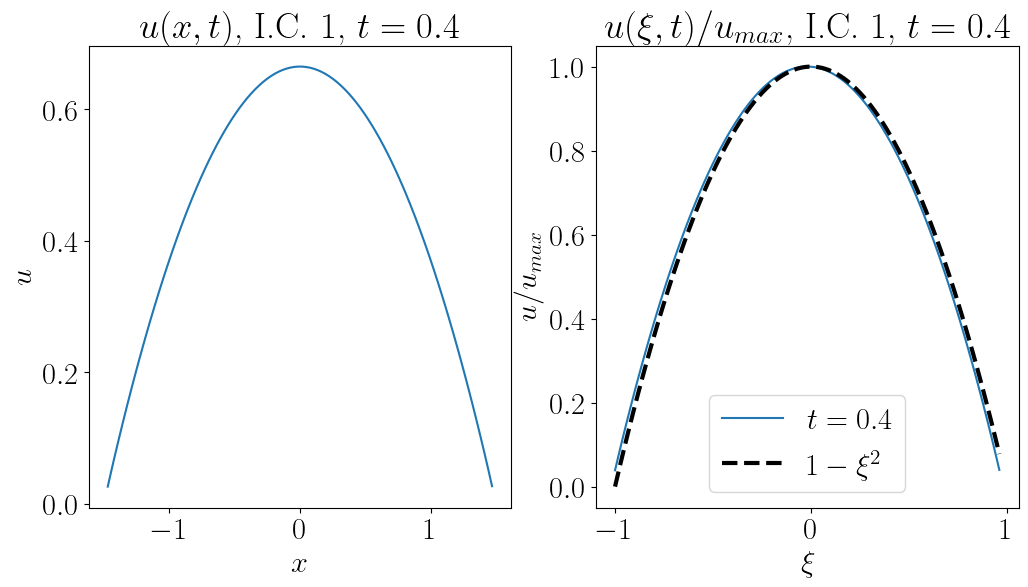

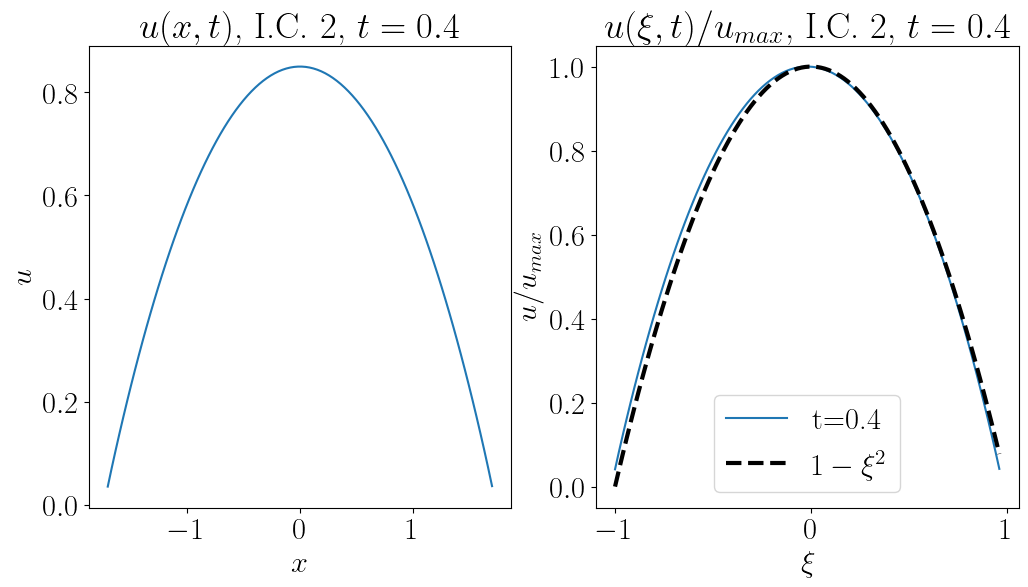

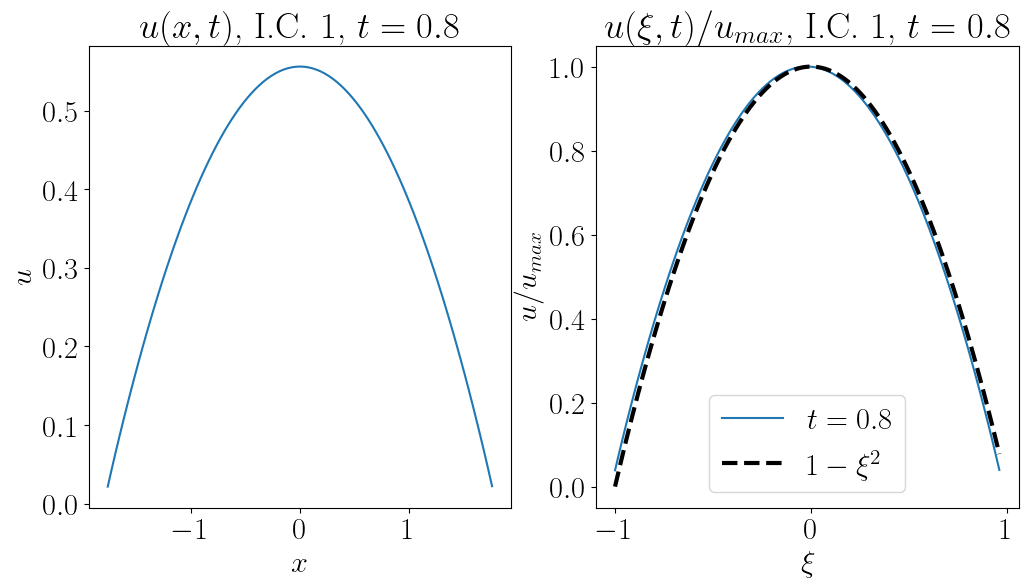

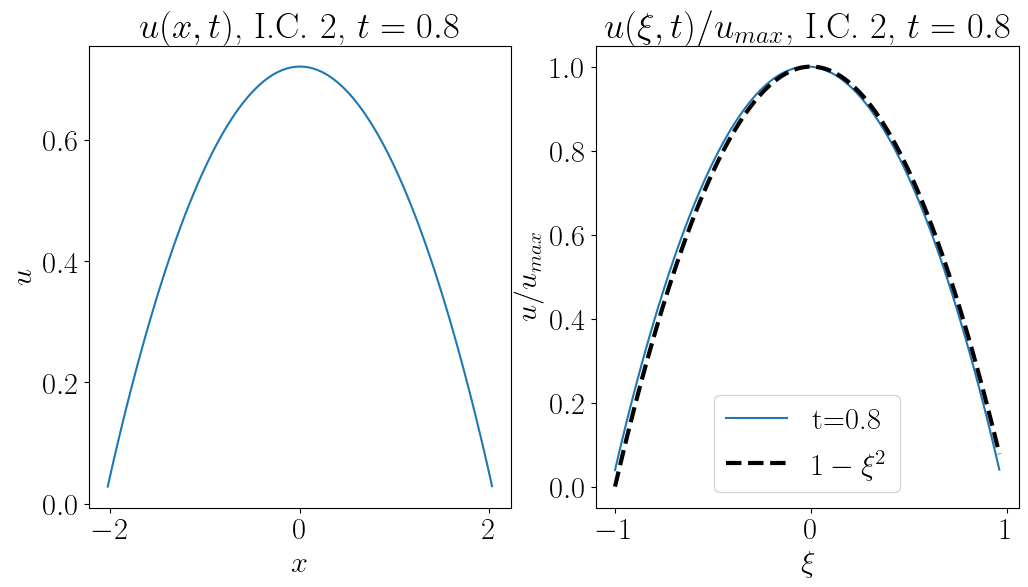

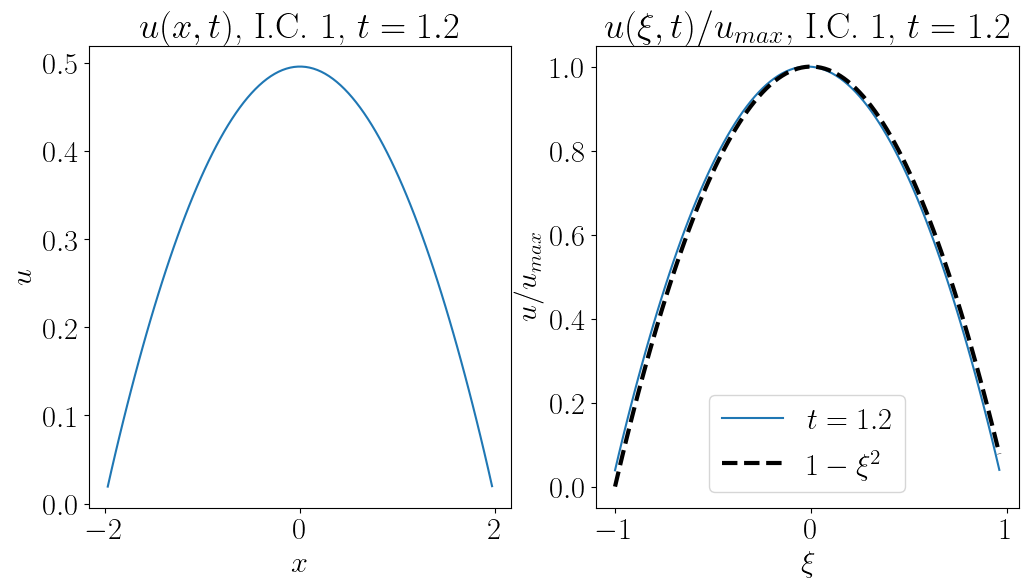

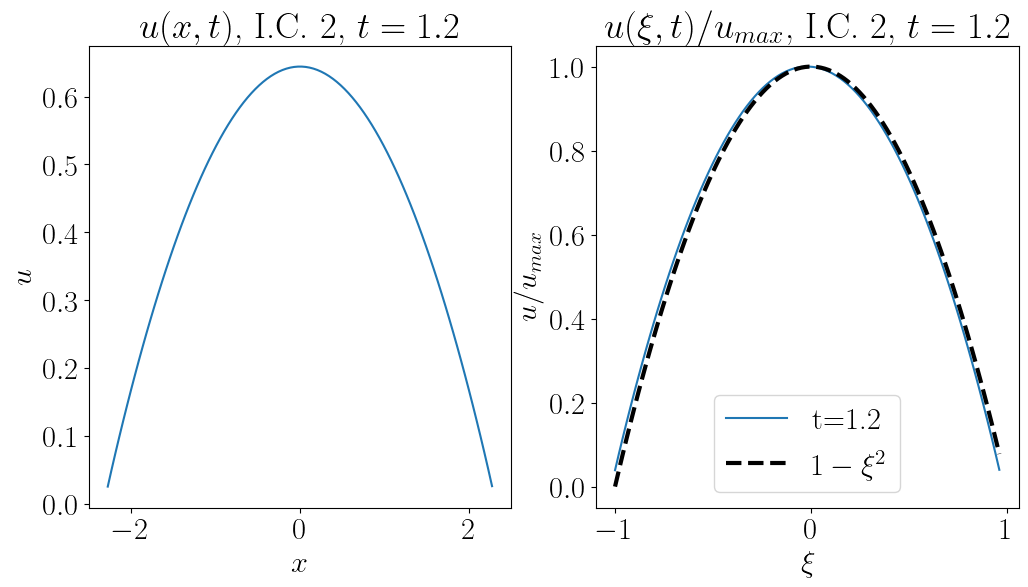

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Set the font family to serif
    "font.serif": ["Times New Roman"],  # Specify the serif font
    "font.size": 22,  # Set the default font size
})
def boussinesq_rhs(t, y, n, h, xi):
    """RHS of the Boussinesq equation in transformed coordinates."""
    u = y[:-2]
    xl = y[-2]
    xr = y[-1]
    xf = (xr - xl) / 2

    dxi_u_left = (4 * u[0] - u[1]) / (2 * h)
    dxi_u_right = (-4 * u[-1] + u[-2]) / (2 * h)

    dxi_u = np.zeros(n)
    dxixi_u = np.zeros(n)

    # Central differences for inner points
    dxi_u[1:-1] = (u[2:] - u[:-2]) / (2 * h)
    dxixi_u[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / (h**2)

    # One-sided differences for boundary points
    dxi_u[0] = (u[1] - u[0]) / h
    dxi_u[-1] = (u[-1] - u[-2]) / h
    dxixi_u[0] = (2 * u[0] - 5 * u[1] + 4 * u[2] - u[3]) / (h**2)
    dxixi_u[-1] = (2 * u[-1] - 5 * u[-2] + 4 * u[-3] - u[-4]) / (h**2)

    du_dt = (1 / xf**2) * (u * dxixi_u + dxi_u**2 - 0.5 * ((1 + xi) * dxi_u_right + (1 - xi) * dxi_u_left) * dxi_u)

    dxl_dt = -dxi_u_left / xf
    dxr_dt = -dxi_u_right / xf

    return np.concatenate((du_dt, [dxl_dt, dxr_dt]))

def solve_boussinesq(u0_func, n, t_span, t_eval):
    """Solves the Boussinesq equation with the given initial condition."""
    h = 2 / (n + 1)
    xi = -1 + np.arange(n) * h

    xl0 = -1
    xr0 = 1
    xf0 = (xr0 - xl0) / 2
    x00 = (xr0 + xl0) / 2

    x0 = x00 + xi * xf0
    u0 = u0_func(x0)

    y0 = np.concatenate((u0, [xl0, xr0]))

    sol = solve_ivp(boussinesq_rhs, t_span, y0, t_eval=t_eval, method='LSODA', args=(n, h, xi))

    return sol, xi

# Initial conditions
def u0_1(x):
    return np.where(np.abs(x) < 1, 1 - x**2, 0)

def u0_2(x):
    return np.where(np.abs(x) < 1, 1 - 0.99 * np.cos(2 * np.pi * x), 0)

# Parameters
n = 100
t_span = (0, 1.2)
t_eval = np.linspace(0, 1.2, 4, endpoint=True)

# Solve for the first initial condition
sol1, xi = solve_boussinesq(u0_1, n, t_span, t_eval)

# Solve for the second initial condition
sol2, xi = solve_boussinesq(u0_2, n, t_span, t_eval)

# Plotting
for i in range(len(t_eval)):
    plt.figure(figsize=(12, 6))

    # First initial condition
    plt.subplot(1, 2, 1)
    xf1 = (sol1.y[-1, i] - sol1.y[-2, i]) / 2
    x01 = (sol1.y[-1, i] + sol1.y[-2, i]) / 2
    x1 = x01 + xi * xf1
    plt.plot(x1, sol1.y[:-2, i], label=f't={t_eval[i]:.1f}')
    plt.title(f'$u(x, t)$, I.C. 1, $t={t_eval[i]:.1f}$')
    plt.xlabel('$x$')
    plt.ylabel('$u$')

    plt.subplot(1, 2, 2)
    umax1 = np.max(sol1.y[:-2, i])
    plt.plot(xi, sol1.y[:-2, i] / umax1, label=f'$t={t_eval[i]:.1f}$')
    plt.plot(xi, 1 - xi**2, 'k--', linewidth=3, label='$1 - \\xi^2$')
    plt.title(f'$u(\\xi, t) / u_{{max}}$, I.C. 1, $t={t_eval[i]:.1f}$')
    plt.xlabel('$\\xi$')
    plt.ylabel('$u / u_{{max}}$')
    plt.legend()

    # plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))

    # Second initial condition
    plt.subplot(1, 2, 1)
    xf2 = (sol2.y[-1, i] - sol2.y[-2, i]) / 2
    x02 = (sol2.y[-1, i] + sol2.y[-2, i]) / 2
    x2 = x02 + xi * xf2
    plt.plot(x2, sol2.y[:-2, i], label=f't={t_eval[i]:.1f}')
    plt.title(f'$u(x, t)$, I.C. 2, $t={t_eval[i]:.1f}$')
    plt.xlabel('$x$')
    plt.ylabel('$u$')

    plt.subplot(1, 2, 2)
    umax2 = np.max(sol2.y[:-2, i])
    plt.plot(xi, sol2.y[:-2, i] / umax2, label=f't={t_eval[i]:.1f}')
    plt.plot(xi, 1 - xi**2, 'k--', linewidth=3, label='$1 - \\xi^2$')
    plt.title(f'$u(\\xi, t) / u_{{max}}$, I.C. 2, $t={t_eval[i]:.1f}$')
    plt.xlabel('$\\xi$')
    plt.ylabel('$u / u_{{max}}$')
    plt.legend()

    # plt.tight_layout()
    plt.show()

/home/daniel/grad/CMSC661/cmsc661-dev/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/daniel/grad/CMSC661/cmsc661-dev/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


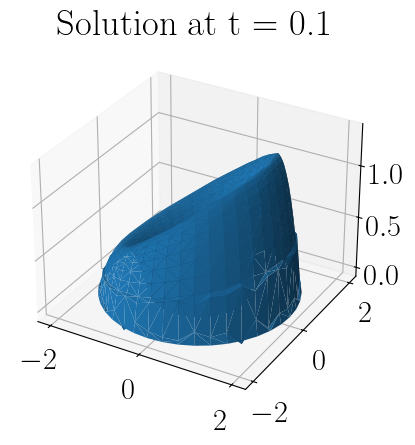

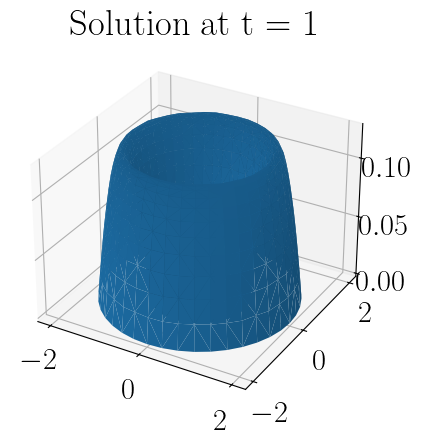

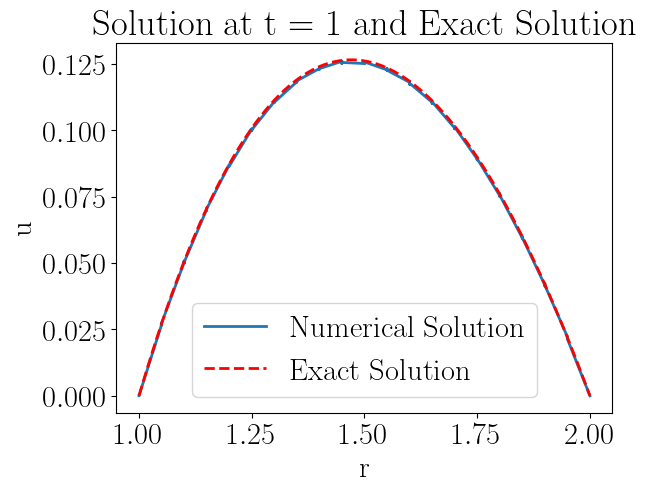

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay

# Parameters
dt = 0.01
T = 1
Nsteps = int(T / dt)

# Mesh Generation (using triangular mesh in polar coordinates)
nr = 20  # Number of radial elements
nphi = 40  # Number of angular elements

r_nodes = np.linspace(1, 2, nr + 1)
phi_nodes = np.linspace(0, 2 * np.pi, nphi + 1)

R, Phi = np.meshgrid(r_nodes, phi_nodes[:-1])  # Exclude last phi node

x = R * np.cos(Phi)
y = R * np.sin(Phi)

# Generate triangles
tri = Delaunay(np.column_stack((x.flatten(), y.flatten())))

coordinates = np.column_stack((x.flatten(), y.flatten()))
elements = tri.simplices

# Number of nodes and elements
Nnodes = coordinates.shape[0]
Nelements = elements.shape[0]

# Basis functions (linear on triangles)
# Mass and Stiffness Matrices
M = csr_matrix((Nnodes, Nnodes), dtype=float)
S = csr_matrix((Nnodes, Nnodes), dtype=float)
F = np.zeros(Nnodes)

for i in range(Nelements):
    nodes = elements[i, :]
    x1, y1 = coordinates[nodes[0]]
    x2, y2 = coordinates[nodes[1]]
    x3, y3 = coordinates[nodes[2]]
    
    area = 0.5 * abs((x2 - x1) * (y3 - y1) - (x3 - x1) * (y2 - y1))
    
    # Linear basis function gradients
    grad1 = np.array([(y2 - y3) / (2 * area), (x3 - x2) / (2 * area)])
    grad2 = np.array([(y3 - y1) / (2 * area), (x1 - x3) / (2 * area)])
    grad3 = np.array([(y1 - y2) / (2 * area), (x2 - x1) / (2 * area)])
    
    # Local Mass and Stiffness Matrices
    localM = area / 12 * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])
    localS = area * np.array([[np.dot(grad1, grad1), np.dot(grad1, grad2), np.dot(grad1, grad3)],
                               [np.dot(grad2, grad1), np.dot(grad2, grad2), np.dot(grad2, grad3)],
                               [np.dot(grad3, grad1), np.dot(grad3, grad2), np.dot(grad3, grad3)]])
    
    # Global Assembly
    for j in range(3):
        for k in range(3):
            M[nodes[j], nodes[k]] += localM[j, k]
            S[nodes[j], nodes[k]] += localS[j, k]
        F[nodes[j]] += area / 3  # Load vector

# Boundary Conditions (Dirichlet)
r_coords = np.sqrt(coordinates[:, 0]**2 + coordinates[:, 1]**2)
boundary_nodes = np.where((abs(r_coords - 1) < 1e-10) | (abs(r_coords - 2) < 1e-10))[0]

for i in boundary_nodes:
    M[i, :] = 0
    M[i, i] = 1
    S[i, :] = 0
    F[i] = 0

# Initial Condition
r_init = np.sqrt(coordinates[:, 0]**2 + coordinates[:, 1]**2)
phi_init = np.arctan2(coordinates[:, 1], coordinates[:, 0])
U = r_init + np.cos(phi_init)

# Time Stepping
U_all = np.zeros((Nnodes, Nsteps + 1))
U_all[:, 0] = U

for n in range(Nsteps):
    U = spsolve(M + dt / 2 * S, (M - dt / 2 * S) @ U + dt * F)
    U_all[:, n + 1] = U

    # Apply BC at each step
    U[boundary_nodes] = 0

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(coordinates[:, 0], coordinates[:, 1], U_all[:, int(0.1 / dt)], triangles=elements)
ax.set_title('Solution at t = 0.1')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(coordinates[:, 0], coordinates[:, 1], U_all[:, Nsteps], triangles=elements)
ax.set_title('Solution at t = 1')
plt.show()

fig = plt.figure()
u = U_all[:, Nsteps]
r = np.sqrt(coordinates[:, 0]**2 + coordinates[:, 1]**2)
sort_indices = np.argsort(r)
rsort = r[sort_indices]
usort = u[sort_indices]
plt.plot(rsort, usort, linewidth=2)

# Exact Stationary Solution
r_exact = np.linspace(1, 2, 100)
u_exact = (1 - r_exact**2) / 4 + 3 * np.log(r_exact) / (4 * np.log(2))
plt.plot(r_exact, u_exact, 'r--', linewidth=2)

plt.title('Solution at t = 1 and Exact Solution')
plt.legend(['Numerical Solution', 'Exact Solution'])
plt.xlabel('r')
plt.ylabel('u')
plt.show()